
----- Analytical Solution for Free Thermal Contraction -----
Temperature change: -293.15 K
Thermal strain: -3.517800e-03
Initial dimensions (mm): 5.00 × 1.00 × 1.00
Change in length (mm): -0.017589, -0.003518, -0.003518
Final dimensions (mm): 4.982411 × 0.996482 × 0.996482
Volume change: -0.052582 mm³ (-1.0516%)

----- FEM Solution for Free Thermal Contraction -----
X-displacement at x=5.0: -0.017561 mm
Y-displacement at y=1.0: -0.003518 mm
Z-displacement at z=1.0: -0.003528 mm


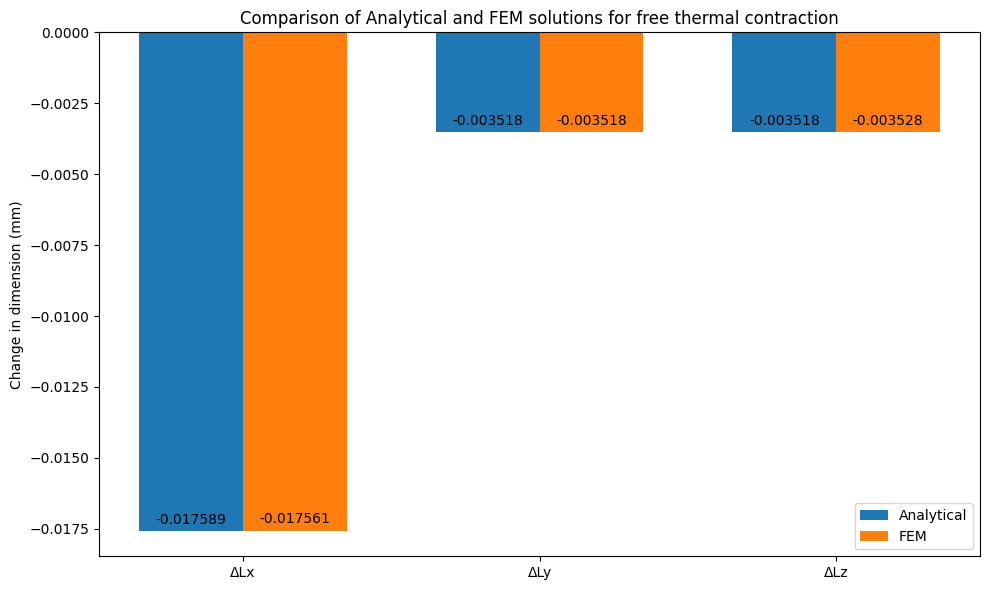

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import dolfinx
from dolfinx import mesh, fem
from dolfinx.fem.petsc import LinearProblem
from dolfinx.io import XDMFFile
import ufl
from mpi4py import MPI
from petsc4py import PETSc

# Create communicator
comm = MPI.COMM_WORLD

# ------ Material properties ------
E = 210e3  # Young's modulus (MPa)
nu = 0.3   # Poisson's ratio
alpha = 1.2e-5  # Thermal expansion coefficient (1/K)

# ------ Geometry parameters ------
Lx, Ly, Lz = 5.0, 1.0, 1.0  # Initial dimensions (mm)
nx, ny, nz = 50, 10, 10     # Mesh divisions

# ------ Thermal parameters ------
initial_temp = 293.15  # Initial temperature (K)
final_temp = 0    # Final temperature (K) - cooling by 20K

# Calculate temperature change
delta_T = final_temp - initial_temp  # Negative for cooling

# ------ Analytical solution for free thermal contraction ------
def analytical_solution():
    """Calculate the analytical solution for free thermal contraction"""
    # For free contraction, strain is simply thermal strain
    thermal_strain = alpha * delta_T  # Negative for cooling

    # Change in dimensions
    delta_Lx = thermal_strain * Lx
    delta_Ly = thermal_strain * Ly
    delta_Lz = thermal_strain * Lz

    # Final dimensions
    final_Lx = Lx + delta_Lx
    final_Ly = Ly + delta_Ly
    final_Lz = Lz + delta_Lz

    # Volume change
    initial_volume = Lx * Ly * Lz
    final_volume = final_Lx * final_Ly * final_Lz
    volume_change = final_volume - initial_volume

    print("\n----- Analytical Solution for Free Thermal Contraction -----")
    print(f"Temperature change: {delta_T:.2f} K")
    print(f"Thermal strain: {thermal_strain:.6e}")
    print(f"Initial dimensions (mm): {Lx:.2f} × {Ly:.2f} × {Lz:.2f}")
    print(f"Change in length (mm): {delta_Lx:.6f}, {delta_Ly:.6f}, {delta_Lz:.6f}")
    print(f"Final dimensions (mm): {final_Lx:.6f} × {final_Ly:.6f} × {final_Lz:.6f}")
    print(f"Volume change: {volume_change:.6f} mm³ ({100*volume_change/initial_volume:.4f}%)")

    return thermal_strain, delta_Lx, delta_Ly, delta_Lz

# ------ FEM solution for free thermal contraction ------
def fem_solution():
    """Calculate the FEM solution for free thermal contraction"""
    print("\n----- FEM Solution for Free Thermal Contraction -----")

    # Create mesh
    domain = mesh.create_box(comm, [np.array([0.0, 0.0, 0.0]), np.array([Lx, Ly, Lz])], [nx, ny, nz])

    # Function space for displacement
    V = fem.functionspace(domain, ("Lagrange", 1, (domain.geometry.dim,)))

    # Define strain and stress
    def eps(u):
        """Strain tensor"""
        return ufl.sym(ufl.grad(u))

    # Calculate Lamé parameters
    mu = E / (2.0 * (1.0 + nu))
    lmbda = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))

    # Define mechanical stress (without thermal component)
    def sigma_mech(epsilon):
        """Mechanical stress tensor"""
        return 2.0 * mu * epsilon + lmbda * ufl.tr(epsilon) * ufl.Identity(3)

    # Define thermal strain tensor
    def get_thermal_strain(T_field):
        """Thermal strain tensor"""
        return alpha * T_field * ufl.Identity(3)

    # Define boundary conditions (Fix displacement at origin)
    def fixed_point(x):
        return np.isclose(x[0], 0.0) & np.isclose(x[1], 0.0) & np.isclose(x[2], 0.0)

    # Locate boundary vertices at origin
    vertices = mesh.locate_entities_boundary(domain, 0, fixed_point)
    dofs = fem.locate_dofs_topological(V, 0, vertices)
    bcs = [fem.dirichletbc(np.zeros(3), dofs, V)]

    # Create temperature field (uniform temperature change)
    T_space = fem.functionspace(domain, ("Lagrange", 1))
    T = fem.Function(T_space)
    T.interpolate(lambda x: np.full(x.shape[1], delta_T))

    # Setup variational problem
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)

    # Create thermal strain tensor
    thermal_strain = get_thermal_strain(T)

    # Bilinear form - mechanical part
    a = ufl.inner(sigma_mech(eps(u)), eps(v)) * ufl.dx

    # Linear form - thermal part
    L = ufl.inner((3*lmbda + 2*mu) * thermal_strain, eps(v)) * ufl.dx

    # Create function for solution
    u_sol = fem.Function(V)



    # Setup solver
    opts = PETSc.Options()
    opts.setValue("ksp_type", "gmres")
    opts.setValue("pc_type", "gamg")  # Using GAMG (algebraic multigrid)
    opts.setValue("ksp_rtol", 1.0e-9)
    opts.setValue("ksp_atol", 1.0e-9)
    opts.setValue("ksp_max_it", 1000)
    opts.setValue("ksp_monitor", None)  # Monitor convergence
    problem = LinearProblem(a, L, bcs=bcs, u=u_sol)

    # Solve the problem
    u_sol = problem.solve()

    # Extract displacement values at specific points
    u_values = u_sol.x.array
    num_nodes = u_values.size // 3
    u_array = np.zeros((num_nodes, 3))
    u_array[:, 0] = u_values[0::3]  # x-components
    u_array[:, 1] = u_values[1::3]  # y-components
    u_array[:, 2] = u_values[2::3]  # z-components

    # Get coordinates
    x = domain.geometry.x

    # Find displacements at critical points with tolerance
    tol = 1e-6
    right_end_nodes = np.where(np.isclose(x[:, 0], Lx, rtol=tol, atol=tol))[0]
    top_end_nodes = np.where(np.isclose(x[:, 1], Ly, rtol=tol, atol=tol))[0]
    front_end_nodes = np.where(np.isclose(x[:, 2], Lz, rtol=tol, atol=tol))[0]

    if len(right_end_nodes) > 0:
        delta_Lx = u_array[right_end_nodes[0], 0]
    else:
        delta_Lx = np.min(u_array[:, 0])  # Fallback to min displacement

    delta_Ly = np.min(u_array[:, 1])
    delta_Lz = np.min(u_array[:, 2])

    print(f"X-displacement at x={Lx}: {delta_Lx:.6f} mm")
    print(f"Y-displacement at y={Ly}: {delta_Ly:.6f} mm")
    print(f"Z-displacement at z={Lz}: {delta_Lz:.6f} mm")

    return delta_Lx, delta_Ly, delta_Lz





# ------ Visualization function ------
def plot_comparison(analytical_results, fem_results):
    """Create a bar plot comparing analytical and FEM results"""
    labels = ['ΔLx', 'ΔLy', 'ΔLz']
    analytical_values = analytical_results[1:]  # Skip thermal strain
    fem_values = fem_results

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, analytical_values, width, label='Analytical')
    rects2 = ax.bar(x + width/2, fem_values, width, label='FEM')

    ax.set_ylabel('Change in dimension (mm)')
    ax.set_title('Comparison of Analytical and FEM solutions for free thermal contraction')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Add values on bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.6f}',
                       xy=(rect.get_x() + rect.get_width()/2, height),
                       xytext=(0, 3),  # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.savefig("free_thermal_contraction_comparison.png")
    plt.show()

def main():
    # Calculate analytical solution
    analytical_results = analytical_solution()

    # Calculate FEM solution
    fem_results = fem_solution()

    # Plot comparison
    plot_comparison(analytical_results, fem_results)



if __name__ == "__main__":
    main()